In [ ]:
import numpy as np
np.random.seed(15)
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as pdr
import datetime as dt

In [ ]:
# Load data
target = 'ETH-USD'
start = dt.datetime(2015,1,1)
end = dt.datetime.today()

data = pdr.DataReader(target, 'yahoo', start, end)
data.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-08-06,3.536610,2.521120,2.831620,2.772120,164329.0,2.772120
2015-08-07,2.798810,0.714725,2.793760,0.753325,674188.0,0.753325
2015-08-08,0.879810,0.629191,0.706136,0.701897,532170.0,0.701897
2015-08-09,0.729854,0.636546,0.713989,0.708448,405283.0,0.708448
2015-08-10,1.131410,0.663235,0.708087,1.067860,1463100.0,1.067860


# Multivariate Prophet

In [ ]:
data['y'] = data['Close']
data['y'] = data['y'].shift(-1)

i = 0
x = 1
for n in data.columns.values[:len(data.columns.values)-1]:
  n = 'add' + str(x)
  data.columns.values[i] = n
  i += 1
  x += 1

data.tail(1)['y'].fillna((float(0)), inplace=True)

data.tail()

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,add1,add2,add3,add4,add5,add6,y
Date,,,,,,,
2021-03-09,1868.048828,1804.266357,1835.148071,1868.048828,2.346124e+10,1868.048828,1799.166260
2021-03-10,1873.803223,1766.490479,1868.489014,1799.166260,2.515417e+10,1799.166260,1826.194946
2021-03-11,1843.818848,1734.617065,1798.033936,1826.194946,2.401313e+10,1826.194946,1772.102417
2021-03-12,1839.497314,1728.980957,1826.546753,1772.102417,2.243582e+10,1772.102417,1773.714600
2021-03-13,1777.229492,1734.528442,1754.122559,1773.714600,2.189302e+10,1773.714600,0.000000


In [ ]:
df = data.dropna()
df.reset_index(level = 0, inplace = True)
df.rename(columns={'Date': 'ds'}, inplace = True)
next_day = df.tail(1)
df.drop(next_day.index, inplace=True)
df.tail()

,ds,add1,add2,add3,add4,add5,add6,y
2036,2021-03-08,1835.192139,1670.942017,1724.229248,1834.727905,2.763099e+10,1834.727905,1868.048828
2037,2021-03-09,1868.048828,1804.266357,1835.148071,1868.048828,2.346124e+10,1868.048828,1799.166260
2038,2021-03-10,1873.803223,1766.490479,1868.489014,1799.166260,2.515417e+10,1799.166260,1826.194946
2039,2021-03-11,1843.818848,1734.617065,1798.033936,1826.194946,2.401313e+10,1826.194946,1772.102417
2040,2021-03-12,1839.497314,1728.980957,1826.546753,1772.102417,2.243582e+10,1772.102417,1772.376221


In [ ]:
train_size = 0.90 # testing only on the very last prices

n_train = round(df.shape[0]*train_size)

# use last days as test data

# train = df[:n_train]
# test = df[n_train:]

# use random days as test data
train = df.drop(index=list(np.random.randint(df.shape[0], size=round(df.shape[0]*(1-train_size)))))
test = df.iloc[list(np.random.randint(df.shape[0], size=round(df.shape[0]*(1-train_size))))]

In [ ]:
from fbprophet import Prophet
prophet = Prophet()
for n in data.columns.values[:len(data.columns.values)-1]:
  prophet.add_regressor(n)
prophet.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


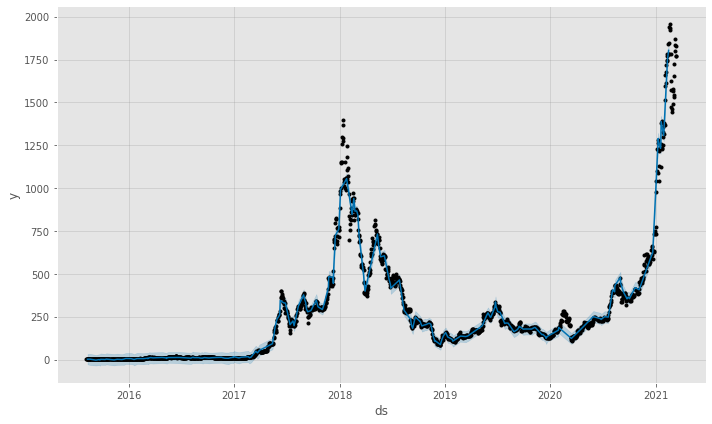

In [ ]:
forecast = prophet.predict(test.drop(columns="y"))
plt.style.use('ggplot')
fig = prophet.plot(forecast)

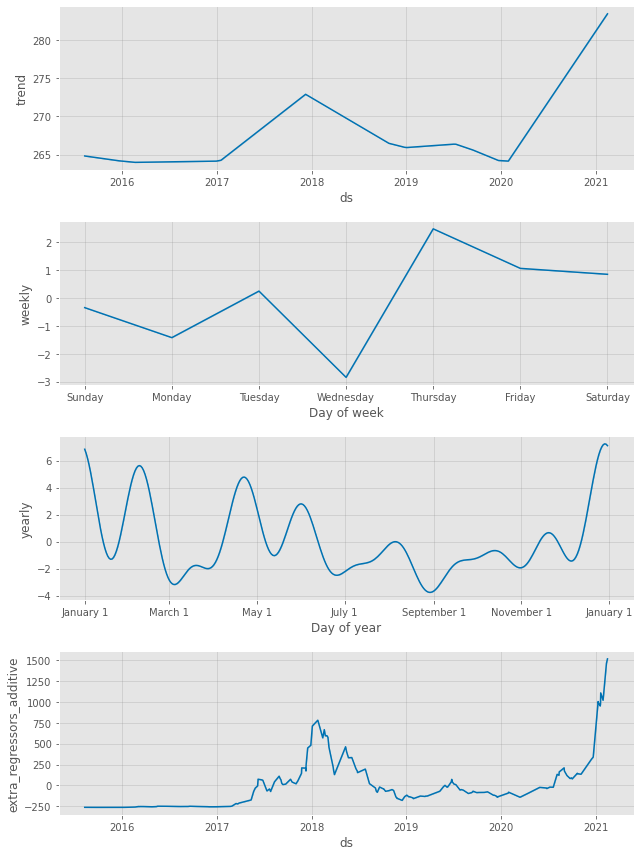

In [ ]:
fig = prophet.plot_components(forecast)

In [ ]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(prophet, initial='730 days', period='180 days', horizon = '365 days')

#https://facebook.github.io/prophet/docs/diagnostics.

# cutoffs = pd.to_datetime([str(x.date()) for x in list(df.tail(3)['ds'])])
# df_cv2 = cross_validation(prophet, cutoffs=cutoffs, horizon='365 days')
df_cv2 = cross_validation(prophet, horizon='365 days')

from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

INFO:fbprophet:Making 6 forecasts with cutoffs between 2017-09-24 00:00:00 and 2020-03-12 00:00:00


INFO:fbprophet:Making 4 forecasts with cutoffs between 2018-09-11 12:00:00 and 2020-03-12 00:00:00


,horizon,mse,rmse,mae,mape,mdape,coverage
0,36 days,305.404359,17.475822,10.288481,0.039814,0.029238,0.885859
1,37 days,290.339788,17.039360,10.129894,0.039393,0.029694,0.886003
2,38 days,269.671991,16.421693,9.834601,0.038699,0.028506,0.890909
3,39 days,295.283335,17.183810,10.166204,0.039073,0.028753,0.884680
4,40 days,273.960392,16.551749,9.912233,0.038102,0.028506,0.888889


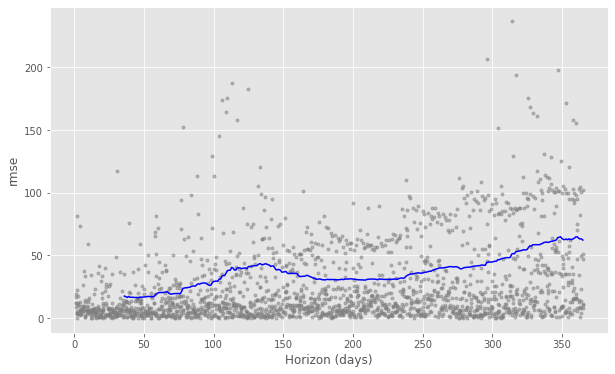

In [ ]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='rmse')

In [ ]:
forecast_next_day = prophet.predict(next_day.drop(columns="y"))
forecast_next_day

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,add1,add1_lower,add1_upper,add2,add2_lower,add2_upper,add3,add3_lower,add3_upper,add4,add4_lower,add4_upper,add5,add5_lower,add5_upper,add6,add6_lower,add6_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-03-13,284.782106,1733.268328,1793.266105,284.782106,284.782106,214.037245,214.037245,214.037245,-42.340519,-42.340519,-42.340519,-93.38979,-93.38979,-93.38979,701.333346,701.333346,701.333346,-0.167161,-0.167161,-0.167161,701.333346,701.333346,701.333346,1479.415033,1479.415033,1479.415033,1480.806467,1480.806467,1480.806467,0.845264,0.845264,0.845264,-2.236699,-2.236699,-2.236699,0.0,0.0,0.0,1764.197139


In [ ]:
date_t = data.tail(1).index.date[0]
price_t = round(float(data.tail(1).values[0][3]), 2)

date_t1 = data.tail(1).index.date[0] + dt.timedelta(days=1)
prediction = round(float(forecast_next_day['yhat'][0]), 2)

print('Price (t):')
print(f'{date_t} {target} {price_t} \n')

print('Price (t+1):')
print(f'{date_t1} {target} {prediction}')

Price (t):
2021-03-13 ETH-USD 1773.71 

Price (t+1):
2021-03-14 ETH-USD 1764.2


# Classification

doesn't work

In [ ]:
import random
random.seed(15)
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from numpy import concatenate

In [ ]:
# Load data
target = 'ETH-USD'
start = dt.datetime(2015,1,1)
end = dt.datetime.today()

df = pdr.DataReader(company, 'yahoo', start, end)
df.head()

In [ ]:
df['UpDown'] = 0
df.reset_index(level = 0, inplace = True)

for index, row in df.iterrows():
  try:
    row['UpDown'] = 1 if row['Close'] < float(df.iloc[[index+1]]['Close']) else 0
  except:
    row['UpDown'] = 0
  df.iloc[index] = row

df.set_index('Date', inplace=True)
df.tail()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data_raw = scaler.fit_transform(df.values)
scaled_data_raw[-1]

In [ ]:
df = df.dropna()
df.drop(df.tail(1).index, inplace=True)
df.shape

In [ ]:
train_size = 0.90
train_df = df.drop(index=random.sample(list(df.index), round(df.shape[0]*(1-train_size))))
test_df = df.loc[random.sample(list(df.index), round(df.shape[0]*(1-train_size)))]

train = scaled_train = scaler.fit_transform(train_df)
test = scaled_test = scaler.fit_transform(test_df)

In [ ]:
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

In [ ]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary(), '\n')
history = model.fit(train_X, train_y, epochs=15, batch_size=50, validation_data=(test_X, test_y), verbose=1, shuffle=False)

In [ ]:
# Evaluation of the model
scores = model.evaluate(test_X, test_y, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
# plot history
plt.style.use('dark_background')
plt.figure(figsize=(20,4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = concatenate((test_X, yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat.reshape((test_X.shape[0], inv_yhat.shape[1])))
inv_yhat = inv_yhat[:,-1]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1]))
inv_y = concatenate((test_X, test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y.reshape((inv_y.shape[0], inv_y.shape[1])))
inv_y = inv_y[:,-1]

# calculate RMSE
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.6f' % rmse)

In [ ]:
# Output

# date = df.index[df['AMZN (t+1)'] == df.values[-1][-1]].date[0] + dt.timedelta(days=1)
date = test_df.index[test_df['UpDown'] == test_df.values[-1][-1]].date[0] + dt.timedelta(days=1)
prediction = round(float(inv_yhat[-1]), 2)

print('Prediction:')
print(f'{date} {target} {prediction}')

In [ ]:
scaled_last_row = np.delete(scaled_data_raw[-1], -1)
scaled_last_row = scaled_last_row.reshape(1, 1, scaled_last_row.shape[0])

prediction = model.predict(scaled_last_row)
scaled_last_row = scaled_last_row.reshape(1, scaled_last_row.shape[2])

full_last_row = concatenate((scaled_last_row, prediction), axis=1)
full_last_row.shape
inv_prediction = scaler.inverse_transform(full_last_row)
inv_prediction = inv_prediction[:,-1]

date_t = df.tail(1).index.date[0]
price_t = round(float(df.tail(1)['Close']), 2)

date_t1 = df.tail(1).index.date[0] + dt.timedelta(days=1)
prediction = round(float(inv_prediction[0]), 2)

print('Price (t):')
print(f'{date_t} {target} {price_t} \n')

print('Prediction (t+1):')
print(f'{date_t1} {target} {prediction}')